# Evaluation Visualization

## Setup

In [8]:
import json
from pathlib import Path
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
import in_data_preprocessor
import ex_data_preprocessor
# Annotations
import eng_silver_misc_coder
import thai_silver_misc_coder
# Code Evaluation
import model_evaluator

## Preprocessing + Annotation + Evaluation

### With Orchestrator

In [6]:
# Preprocessing
in_data_preprocessor.main(in_path=Path("../exported_sessions/all_sessions.json"), out_path=Path("../data/orchestrated/pre_annotate.jsonl"))

FileNotFoundError: Missing ..\exported_sessions\all_sessions.json

In [3]:
# Code Annotation
thai_silver_misc_coder.main(in_path=Path("../data/orchestrated/pre_annotate.jsonl"), out_path=Path("../data/orchestrated/post_annotate.jsonl"))

2025-09-16 17:57:22,473 | INFO | Run config: {"model": "aisingapore/Gemma-SEA-LION-v4-27B-IT", "temperature": 0.0, "threshold": 0.6, "backoff": 0.4, "max_codes_per_utt": 1, "history_window": 6, "base_url": "https://api.sea-lion.ai/v1"}
Processing items:  16%|█▌        | 9/56 [00:33<02:52,  3.68s/item]


KeyboardInterrupt: 

In [5]:
# Evaluation
model_evaluator.main(in_path=Path("../data/orchestrated/post_annotate.jsonl"), out_path=Path("../data/orchestrated/report.json"))

{
  "psychometrics": {
    "n_items": 10,
    "therapist_utts": 5,
    "client_utts": 5,
    "R_over_Q": 1.0,
    "pct_open_questions": 1.0,
    "pct_complex_reflection": 0.0,
    "reflections_per100": 20.0,
    "questions_per100": 20.0,
    "info_per100": 0.0,
    "pct_mi_consistent": 1.0,
    "mico_per100": 80.0,
    "miin_per100": 0.0,
    "client_CT": 0,
    "client_ST": 2,
    "pct_CT_over_CT_plus_ST": 0.0
  },
  "coverage": {
    "therapist_code_counts": {
      "FI": 1,
      "OQ": 1,
      "SR": 1,
      "ADP": 1,
      "SU": 1
    },
    "client_code_counts": {
      "FN": 3,
      "TS-": 2
    }
  },
  "coarse_coverage": {
    "therapist": {
      "TI": 3,
      "QS": 1,
      "RF": 1
    },
    "client": {
      "NT": 3,
      "ST": 2
    }
  },
  "performance": null,
  "meta": {
    "alias_map_applied": true,
    "mico_set": [
      "ADP",
      "AF",
      "CR",
      "EC",
      "OQ",
      "RCP",
      "RF",
      "SR",
      "SU"
    ],
    "miin_set": [
      "ADW",
  

## Visualize

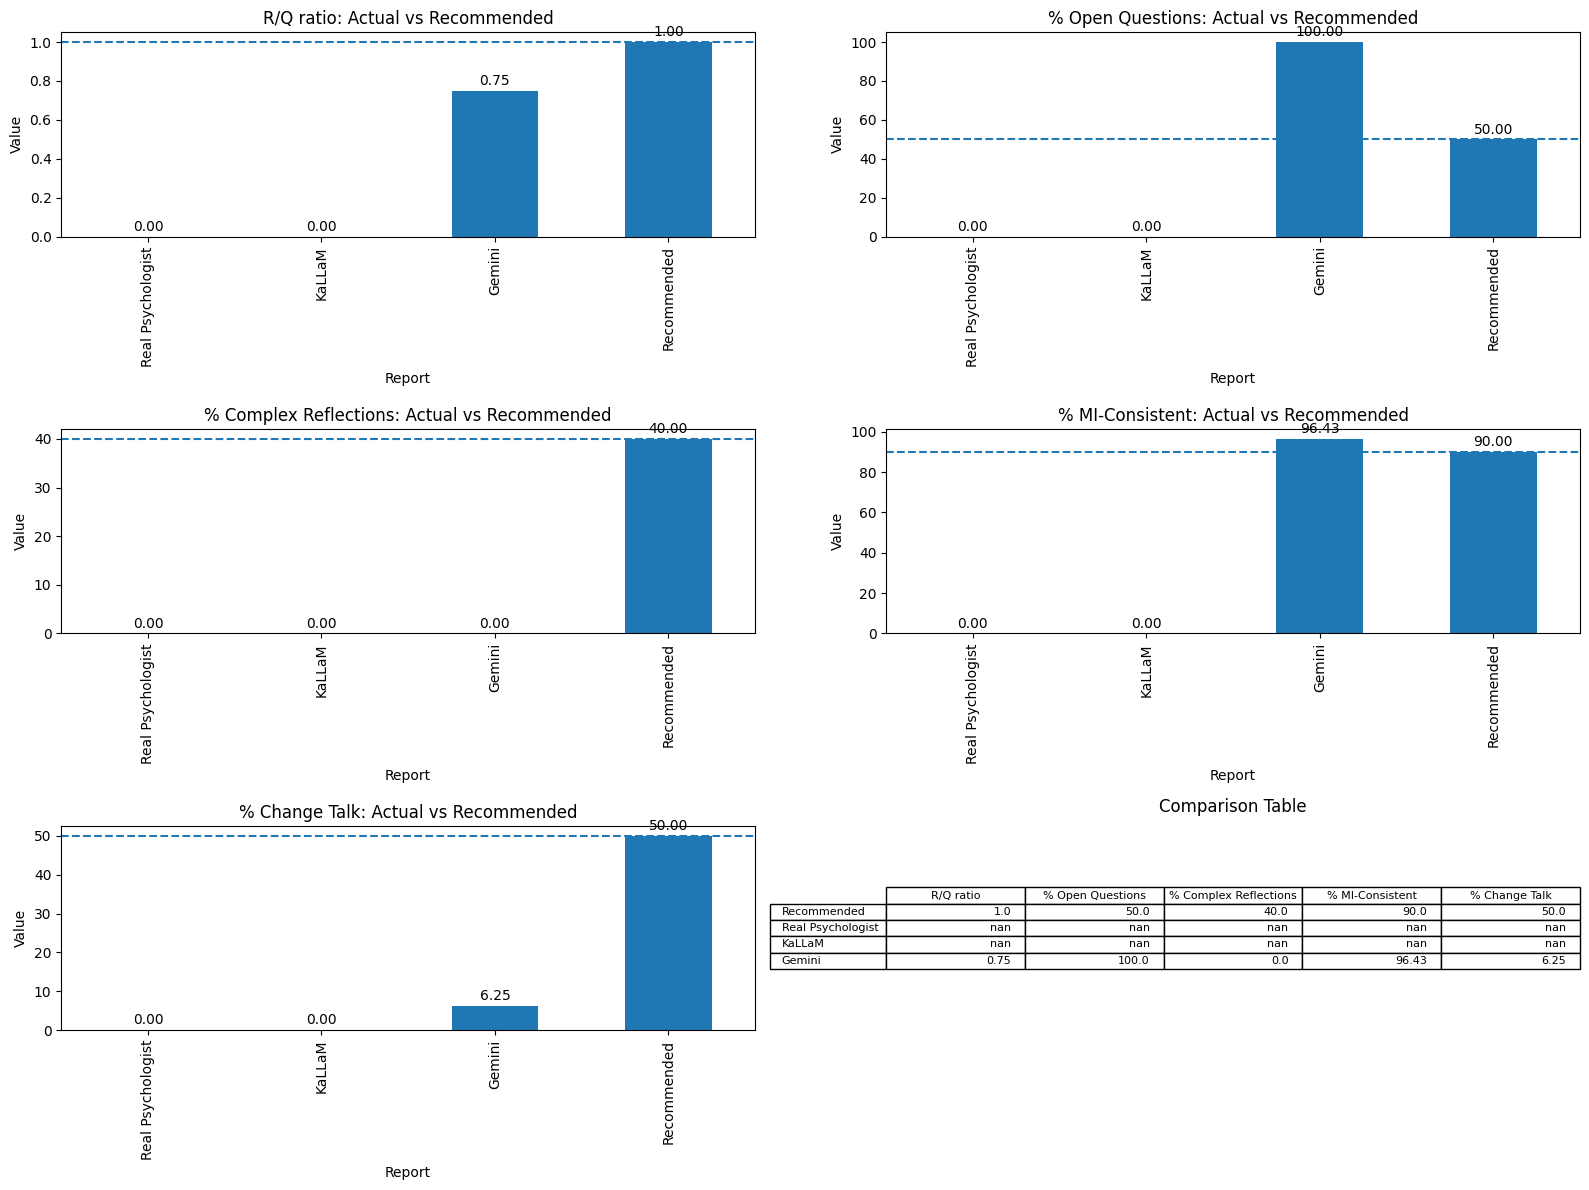

,R/Q ratio,% Open Questions,% Complex Reflections,% MI-Consistent,% Change Talk
Recommended,1.00,50.0,40.0,90.00,50.00
Real Psychologist,NaN,NaN,NaN,NaN,NaN
KaLLaM,NaN,NaN,NaN,NaN,NaN
Gemini,0.75,100.0,0.0,96.43,6.25


In [9]:
REPORT_PATHS = {
    "Real Psychologist": Path("../data/psychologist/report.json"),
    "KaLLaM": Path("../data/orchestrated/report.json"),
    "Gemini": Path("../data/gemini/report.json"),
    
}

RECOMMENDED = {
    "R/Q ratio": 1.0,                # Reflections / Questions >= 1.0
    "% Open Questions": 50.0,       # >= 50%
    "% Complex Reflections": 40.0,  # >= 40%
    "% MI-Consistent": 90.0,        # >= 90%
    "% Change Talk": 50.0           # >= 50%
}

# -----------------
# HELPERS
# -----------------
def load_report(p: Path) -> Dict:
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_metrics(report: Dict) -> Dict[str, float]:
    psy = report.get("psychometrics", {})
    rq = float(psy.get("R_over_Q", 0.0))
    poq = float(psy.get("pct_open_questions", 0.0)) * 100.0
    pcr = float(psy.get("pct_complex_reflection", 0.0)) * 100.0
    mic = psy.get("pct_mi_consistent", psy.get("pct_mi_consistency", psy.get("pct_mi_consist", 0.0)))
    mic = float(mic) * 100.0
    pct_ct = float(psy.get("pct_CT_over_CT_plus_ST", 0.0)) * 100.0

    return {
        "R/Q ratio": rq,
        "% Open Questions": poq,
        "% Complex Reflections": pcr,


        "% MI-Consistent": mic,
        "% Change Talk": pct_ct,
    }

def build_comparison_df(named_paths: Dict[str, Path]) -> pd.DataFrame:
    rows = {}
    for label, p in named_paths.items():
        try:
            metrics = extract_metrics(load_report(p))
            rows[label] = metrics
        except Exception as e:
            rows[label] = {k: np.nan for k in RECOMMENDED.keys()}
    rows["Recommended"] = RECOMMENDED
    return pd.DataFrame(rows).T

# -----------------
# LOAD
# -----------------
df = build_comparison_df(REPORT_PATHS)

# -----------------
# PLOT: one figure with subplots
# -----------------
metrics = ["R/Q ratio", "% Open Questions", "% Complex Reflections", "% MI-Consistent", "% Change Talk"]

fig, axs = plt.subplots(3, 2, figsize=(16, 12))
axs = axs.flatten()

def plot_metric(ax, metric_key: str):
    data = df[[metric_key]].copy()
    data.plot(kind="bar", legend=False, ax=ax)
    ax.set_title(f"{metric_key}: Actual vs Recommended")
    ax.set_ylabel("Value")
    ax.set_xlabel("Report")
    thr = df.loc["Recommended", metric_key]
    ax.axhline(thr, linestyle="--")
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", padding=2)

for i, m in enumerate(metrics):
    plot_metric(axs[i], m)

# Table subplot
ax_tbl = axs[-1]
ax_tbl.axis("off")
tbl_df = df.round(2)
order = ["Recommended"] + [idx for idx in df.index if idx != "Recommended"]
tbl_df = tbl_df.loc[order, metrics]
table = ax_tbl.table(cellText=tbl_df.values,
                     rowLabels=tbl_df.index.tolist(),
                     colLabels=tbl_df.columns.tolist(),
                     loc="center")
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.0, 1.3)
ax_tbl.set_title("Comparison Table", pad=10)

plt.tight_layout()
plt.show()

display(tbl_df)
